In [21]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import addTeamInfo

In [3]:
#データの読み込みと前処理
#train_df = pd.read_csv("Data/Raw/train_data.csv", index_col='id')
#test_df = pd.read_csv("Data/Raw/test_data.csv", index_col="id")

train_df = pd.read_csv("../data/Processed/train_buki.csv", index_col='id')
test_df = pd.read_csv("../data/Processed/test_buki.csv", index_col="id")
print(train_df.shape)
print(test_df.shape)

(66125, 79)
(28340, 78)


In [3]:
train_df.head()

,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,...,subweapon-B3,special-B3,mainweapon-B3,reskin-B3,category1-B4,category2-B4,subweapon-B4,special-B4,mainweapon-B4,reskin-B4
id,,,,,,,,,,,,,,,,,,,,,
1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,soytuber_custom,...,splashbomb,presser,splatcharger,splatcharger,shooter,shooter,quickbomb,kyubanbomb_pitcher,sharp,sharp_neo
2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,jetsweeper,...,jumpbeacon,bubble,campingshelter,campingshelter,shooter,maneuver,torpedo,chakuchi,sputtery,sputtery_clear
3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,quadhopper_black,...,splashbomb,nicedama,prime,prime_becchu,shooter,maneuver,splashbomb,amefurashi,dualsweeper,dualsweeper_custom
4,2019-11-11T14:00:00+00:00,5.0.1,regular,standard,nawabari,engawa,bamboo14mk1,NaN,336,splatroller_becchu,...,kyubanbomb,curlingbomb_pitcher,promodeler_mg,promodeler_mg,shooter,blaster,robotbomb,jetpack,hotblaster,hotblaster_custom
5,2019-12-14T06:00:00+00:00,5.0.1,gachi,standard,hoko,chozame,bold_7,x,299,hissen_hue,...,splashbomb,quickbomb_pitcher,bucketslosher,bucketslosher_soda,shooter,shooter,splashbomb,armor,wakaba,wakaba


In [4]:
np.sum(train_df['y'] == 1) / train_df['y'].count(), np.sum(train_df['y'] == 0) / train_df['y'].count()

(0.524703213610586, 0.47529678638941397)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66125 entries, 1 to 66125
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   period         66125 non-null  object 
 1   game-ver       66125 non-null  object 
 2   lobby-mode     66125 non-null  object 
 3   lobby          66125 non-null  object 
 4   mode           66125 non-null  object 
 5   stage          66125 non-null  object 
 6   A1-weapon      66125 non-null  object 
 7   A1-rank        51681 non-null  object 
 8   A1-level       66125 non-null  int64  
 9   A2-weapon      66125 non-null  object 
 10  A2-rank        51681 non-null  object 
 11  A2-level       66125 non-null  float64
 12  A3-weapon      66125 non-null  object 
 13  A3-rank        51681 non-null  object 
 14  A3-level       66125 non-null  float64
 15  A4-weapon      66074 non-null  object 
 16  A4-rank        51638 non-null  object 
 17  A4-level       66074 non-null  float64
 18  B1-wea

### 変数の種類
#### 数値
・レベル
#### カテゴリ
・それ以外

### 欠損値の起こり方
・回線切れなどでA4、B4が存在しないケースが存在する、回線切れを起こしたチームは負ける確率が高い可能性があるので注意
・ナワバリバトルではランクは欠損値になる

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

drop_cols = ["period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

def make_input(train_df_, test_df_, drop_cols_):
    
    for col in test_df_.columns:
        print(col)
        if col in drop_cols_:
            train_df_.drop(col, axis=1, inplace=True)
            test_df_.drop(col, axis=1, inplace=True)
            continue
        elif test_df_[col].dtype in [int, float]:
            df = pd.concat([train_df_[col], test_df_[col]])
            med = df.median()
            train_df_[col].fillna(med, inplace=True)
            test_df_[col].fillna(med, inplace=True)
            continue
        train_df_[col].fillna('none', inplace=True)
        test_df_[col].fillna('none', inplace=True)
        lbl = LabelEncoder()
        obj = list(set(train_df_[col].to_list() + test_df_[col].to_list()))
        lbl.fit(obj)
        train_df_[col] = lbl.transform(train_df_[col])
        test_df_[col] = lbl.transform(test_df_[col])
    
    y = train_df["y"] 
    train_df_.drop("y", axis=1, inplace=True)
    return train_df, test_df, y

In [7]:
X, test_X, y = make_input(train_df, test_df, drop_cols)

period
game-ver
lobby-mode
lobby
mode
stage
A1-weapon
A1-rank
A1-level
A2-weapon
A2-rank
A2-level
A3-weapon
A3-rank
A3-level
A4-weapon
A4-rank
A4-level
B1-weapon
B1-rank
B1-level
B2-weapon
B2-rank
B2-level
B3-weapon
B3-rank
B3-level
B4-weapon
B4-rank
B4-level
category1-A1
category2-A1
subweapon-A1
special-A1
mainweapon-A1
reskin-A1
category1-A2
category2-A2
subweapon-A2
special-A2
mainweapon-A2
reskin-A2
category1-A3
category2-A3
subweapon-A3
special-A3
mainweapon-A3
reskin-A3
category1-A4
category2-A4
subweapon-A4
special-A4
mainweapon-A4
reskin-A4
category1-B1
category2-B1
subweapon-B1
special-B1
mainweapon-B1
reskin-B1
category1-B2
category2-B2
subweapon-B2
special-B2
mainweapon-B2
reskin-B2
category1-B3
category2-B3
subweapon-B3
special-B3
mainweapon-B3
reskin-B3
category1-B4
category2-B4
subweapon-B4
special-B4
mainweapon-B4
reskin-B4


## ここから自分で実装

In [8]:
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier


random.seed(0)

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [9]:
# 全データを5つに分割
SIZE = X.shape[0]
K = 5

def make_kfolds(SIZE, K):
    # return list object, each element is indices of its fold
    FOLD_SIZE = int(SIZE/K)
    res = []
    indices = [i for i in range(SIZE)]
    for i in range(K-1):
        fold = random.sample(indices, FOLD_SIZE)
        indices = list(set(indices) - set(fold))
        res.append(fold)
    res.append(indices)
    return res

folds = make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    

    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


5
fold  1  size is  13225
fold  2  size is  13225
fold  3  size is  13225
fold  4  size is  13225
fold  5  size is  13225
successfully split


In [17]:
param = {
    "num_leaves" : 20,
    "n_estimators" : 100,
    "learning_rate" : 0.1,
    "num_iterations" : 50,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0

all_indices = sum(folds, [])
for i in range(K):
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices].values
    train_y = y.iloc[train_indices].values
    valid_X = X.iloc[valid_indices].values
    valid_y = y.iloc[valid_indices].values
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    
    model = lgb.train(param, train_data, valid_sets=valid_data, early_stopping_rounds=2, verbose_eval=10)
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.689422
[20]	valid_0's binary_logloss: 0.687497
[30]	valid_0's binary_logloss: 0.68611
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.685742
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.688861
[20]	valid_0's binary_logloss: 0.687088
[30]	valid_0's binary_logloss: 0.686119
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.685701
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.688454
[20]	valid_0's binary_logloss: 0.687102
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.686867
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.687102
[20]	valid_0's binary_logloss: 0.685267
[30]	valid_0's binary_logloss: 0.684259
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.683659
Training until valida

0.5275344066293824
0.5251252592760562
0.5244481515715985
0.5222516726846728
0.5239627635603298
0.524664450744408


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

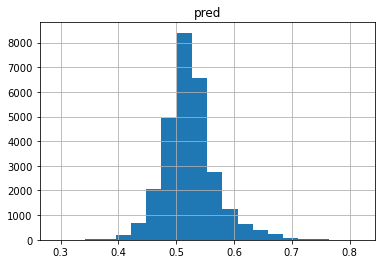

In [18]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=20)

In [12]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
# submit_df.to_csv('Submissions/submission4.csv')

0.7674664784756527
